# EDA for cases data from 2015 to 2021

In [270]:
!python -m pip install tqdm nb-black

In [271]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Basic exploration
We begin by loading the data and looking at its basic shape:

In [272]:
df = pd.read_csv("../data/processed/MVAallcases_cleaned.csv")

In [273]:
# Remove data from years 2020,2021 (There is an issue with the CAD Event IDs)
# df.drop(df[df["Year"] == 2020].index, inplace=True)
df.drop(df.loc[df["Year"].isin([2020, 2021])].index, inplace=True)
df["Call Priority Code"] = df["Call Priority Code"].astype(str)

In [274]:
df.shape

(5509132, 33)

We display the basic cases data:

In [275]:
pd.options.display.max_columns = 100
df.head(5)

,Officer Dispatch UID,Dispatch ID,CAD Event ID,Officer Serial Num,AS Of Officer Title,As_On_Officer Precinct_ID,As_On_Officer Precinct_Desc,As_On_Officer Squad_Desc,Partner Officer Serial Num,Clear By Desc,Call Type Desc,Case Type Initial Desc,Case Type Final Desc,Call Priority Code,GO Num,First Dispatch Time,Clear Time,Total Service Time,Precinct,Sector,Beat,Dispatch Address,Blurred_Latitude,Blurred_Longitude,Year,First Dispatch Year,First Dispatch Month,First Dispatch Weekday,First Dispatch Hour,Clear Year,Clear Month,Clear Weekday,Clear Hour
0,2016000447501V27651,2016000447501V2,2016000447501,7651,POLICE OFFICER,B110,WEST PCT,WEST PCT 2ND W - MARY BEATS,7651,ORAL WARNING GIVEN,ONVIEW,PEDESTRIAN VIOLATIONS,--TRAFFIC - PEDESTRIAN VIOLATION,3,20160000447501,2016-12-13 16:30:25,2016-12-13 16:34:03,3,WEST,MARY,M2,3 AV / PINE ST,47.610743,-122.338702,2016,2016,12,1,16,2016,12,1,16
1,20160002116652R337744,20160002116652R33,2016000211665,7744,POLICE OFFICER,B230,SOUTH PCT,SOUTH PCT 2ND W - ROBERT,7744,PHYSICAL ARREST MADE,ONVIEW,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--NARCOTICS - NARS REPORT,2,20160000211665,2016-06-14 16:20:29,2016-06-14 21:03:43,41,SOUTH,ROBERT,R3,4316 S GENESEE ST,47.564089,-122.278254,2016,2016,6,1,16,2016,6,1,21
2,2016000211088T335251,2016000211088T33,2016000211088,5251,POLICE OFFICER,B630,TRAFFIC SECTION,TRAF - MOTORCYCLE UNIT - T3 SQUAD,-,ASSISTANCE RENDERED,911,"MVC - REPORT, NON INJ/NON BLKG OR AFTER FACT INJ",--TRAFFIC - MV COLLISION INVESTIGATION,3,20160000211088,2016-06-14 08:09:29,2016-06-14 12:28:56,56,NORTH,BOY,B2,8 AV NW / NW 56 ST,47.669428,-122.366179,2016,2016,6,1,8,2016,6,1,12
3,20160003864582U017497,20160003864582U01,2016000386458,7497,POLICE OFFICER,B120,NORTH PCT,NORTH PCT 2ND W - L/U RELIEF,7557,REPORT WRITTEN (NO ARREST),911,DIST - DV - NO ASLT,"--DV - ARGUMENTS, DISTURBANCE (NO ARREST)",2,20160000386458,2016-10-25 14:26:00,2016-10-25 15:01:16,35,NORTH,UNION,U3,5114 26 AV NE,47.666846,-122.299287,2016,2016,10,1,14,2016,10,1,15
4,20160004354893G27752,20160004354893G2,2016000435489,7752,POLICE OFFICER,B240,EAST PCT,EAST PCT 3RD W - GEORGE,7776,ASSISTANCE RENDERED,911,SERVICE - WELFARE CHECK,--DISTURBANCE - OTHER,3,20160000435489,2016-12-03 20:10:25,2016-12-03 22:38:46,15,EAST,GEORGE,G2,140 23 AV S[MONICA'S VILLAGE 403,47.601002,-122.302236,2016,2016,12,5,20,2016,12,5,22


### Columns description
1. ```Officer Dispatch UID```: Dispatch ID + Officer Serial Num
2. ```Dispatch ID```: Dispatch ID
3. ```CAD Event ID```: computer aided dispatch (CAD) event ID number is generated when the service is initiated
4. ```Officer Serial Num```: serial number of the officer 
5. ```AS Of Officer Title```: Officer title
6. ```As_On_Officer Precinct_ID```: precinct ID that dispatched the officer
7. ```As_On_Officer Precinct_Desc```: description of the precinct
8. ```As_On_Officer Squad_Desc```: ?
9. ```Partner Officer Serial Num```: serial number of the partner officer
10. ```Clear By Desc```: how was the case cleared
11. ```Call Type Desc```: type of call that initiated the case
12. ```Case Type Initial Desc```: initial description of the case
13. ```Case Type Final Desc```: final description of the case
14. ```Call Priority Code```: ?
15. ```GO Num```: ID assigned when report is written and submitted
16. ```First Dispatch Time```: time at dispatch
17. ```Clear Time```: time at event was cleared
18. ```Total Service Time```: in min
19. ```Precinct```: precint name (loc?)
20. ```Sector```: ?
21. ```Beat```: ?
22. ```Dispatch Address```: address from which officer was dispatched
23. ```Blurred_Latitude```: ?
24. ```Blurred_Longitude```: ?
25. ```Year```: year of the incident

## Exploring univariate distributions (by Year files)

In [276]:
def barplot_by_year(df, var_colname, col_wrap=3, height=5, aspect=1, top_n=10):
    var_df = (
        df[["CAD Event ID", var_colname, "Year"]]
        .drop_duplicates()
        .sort_values("CAD Event ID")
    )
    var_df_counts = (
        var_df.groupby([var_colname, "Year"])
        .size()
        .sort_values(ascending=False)
        .reset_index()
    )
    var_df_counts_agg = (
        var_df_counts.groupby(["Year", var_colname])
        .agg({0: "sum"})
        .sort_values(0, ascending=False)
    )
    var_df_counts_agg_pcts = (
        var_df_counts_agg.groupby(level=0)
        .apply(lambda x: 100 * x / float(x.sum()))
        .reset_index()
    )

    if len(var_df_counts_agg_pcts[var_colname].unique()) < top_n:
        top_n = len(var_df_counts_agg_pcts[var_colname].unique())

    var_df_counts_agg_pcts_head = (
        var_df_counts_agg_pcts.groupby(["Year"]).head(top_n).reset_index(drop=True)
    )

    g = sns.FacetGrid(
        var_df_counts_agg_pcts_head,
        col="Year",
        col_wrap=col_wrap,
        height=height,
        aspect=aspect,
        sharex=False,
        sharey=False,
    )
    g.map(sns.barplot, var_colname, 0)
    g.set_axis_labels("", "Percent %")
    g.fig.suptitle(var_colname, size="xx-large")
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(
            axes.get_xticklabels(), rotation=70, horizontalalignment="right"
        )
    plt.tight_layout()

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


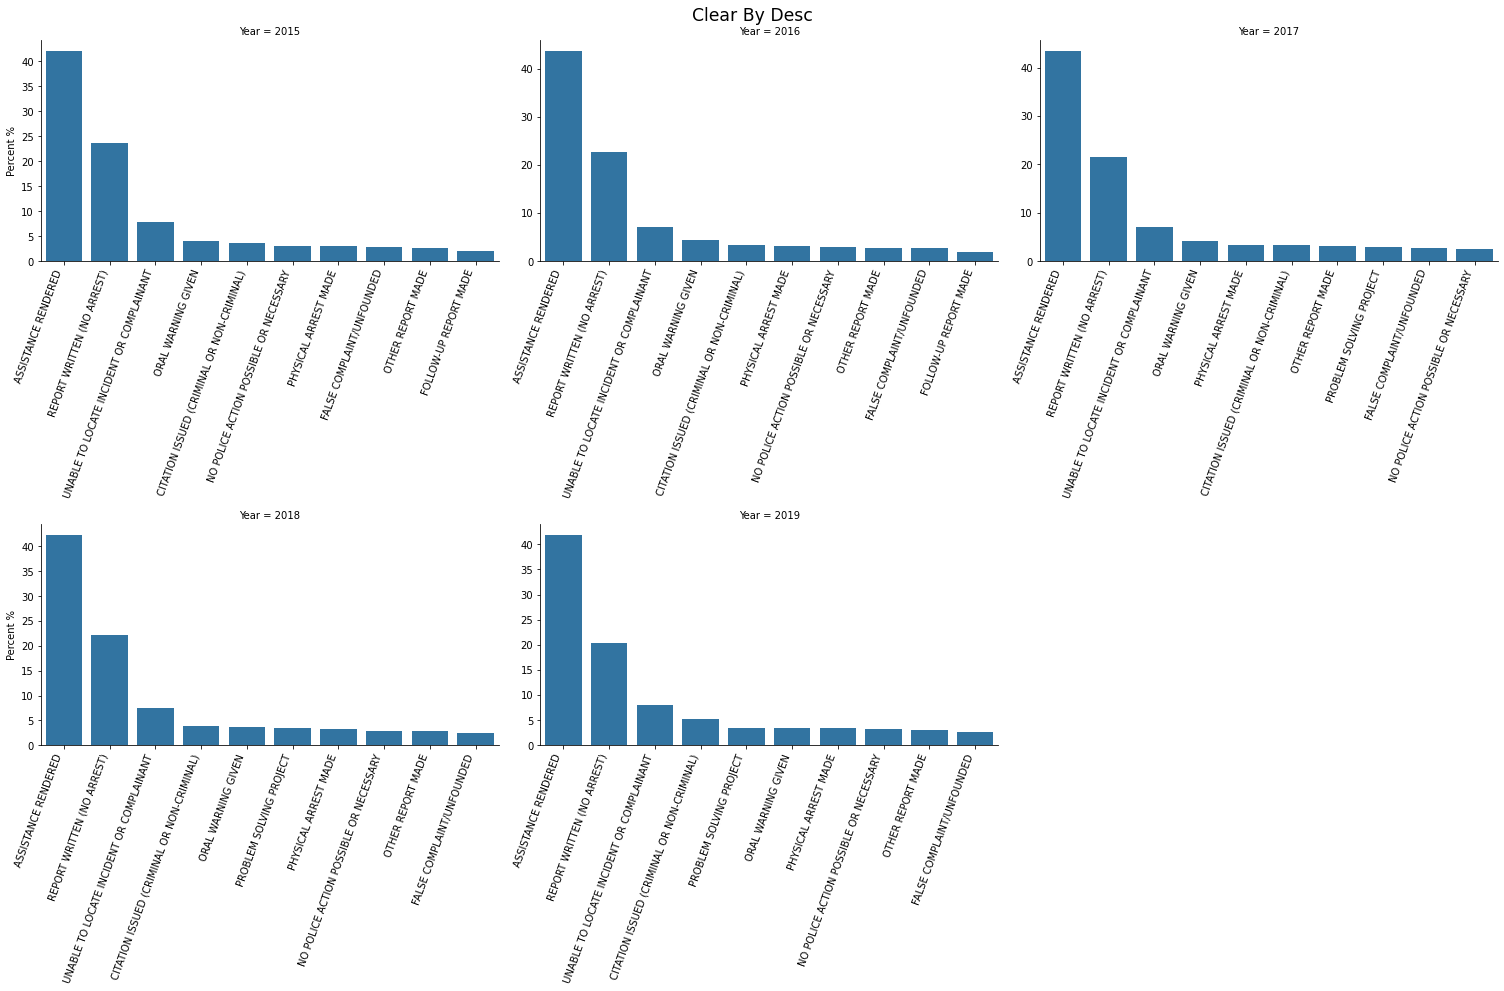

In [277]:
# Clear By desc
barplot_by_year(df, var_colname="Clear By Desc", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


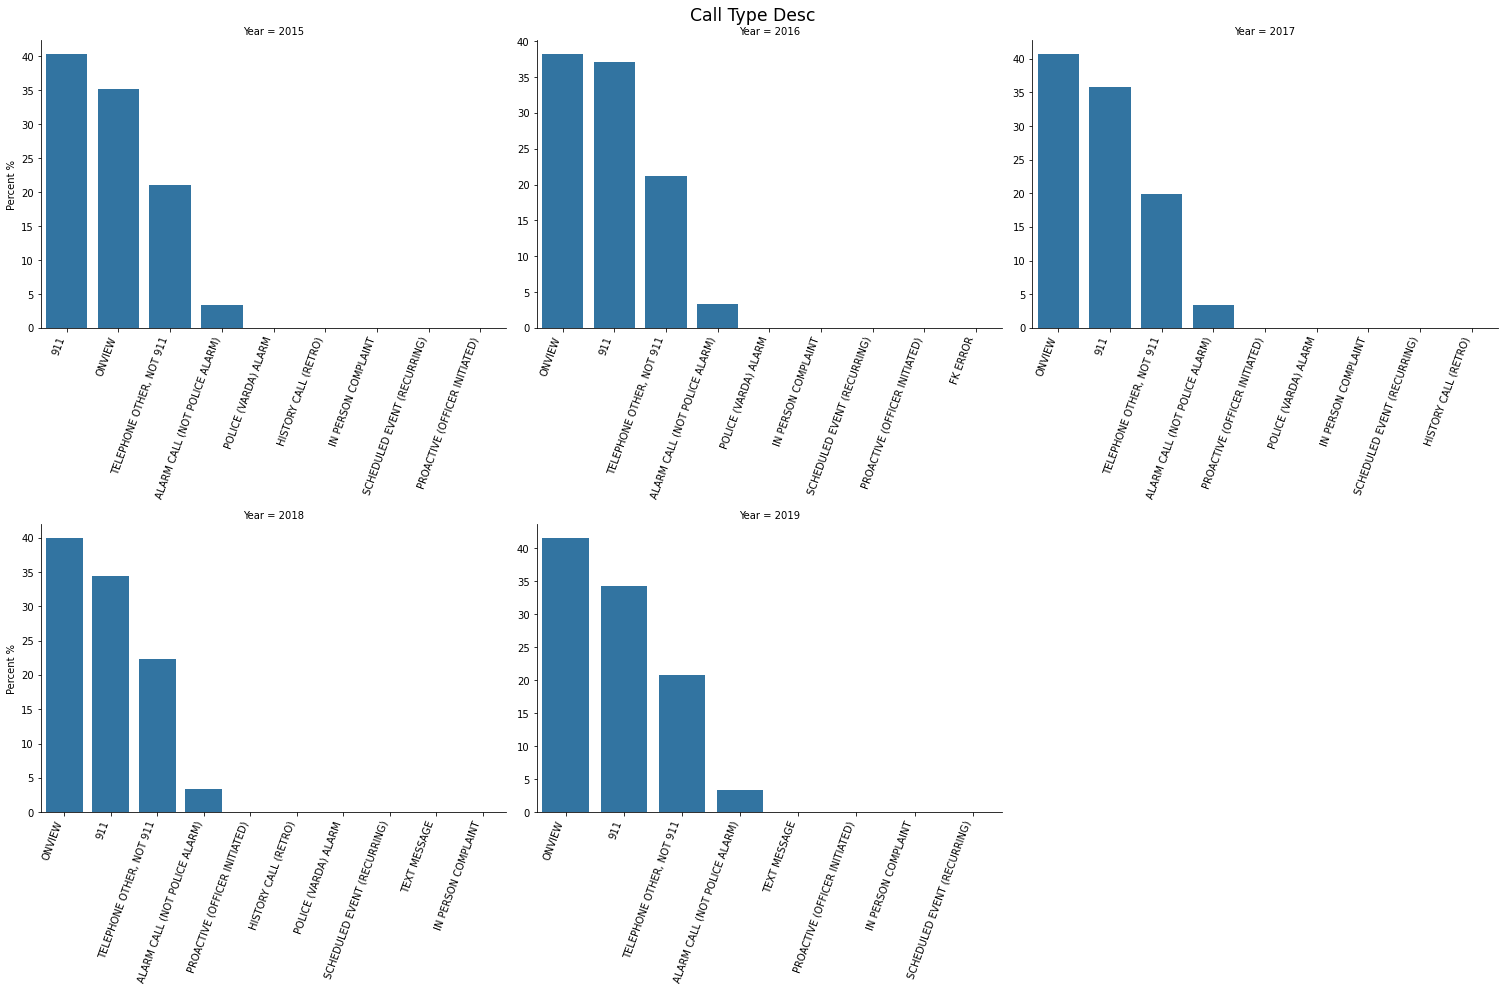

In [278]:
# Case type initial
barplot_by_year(df, var_colname="Call Type Desc", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


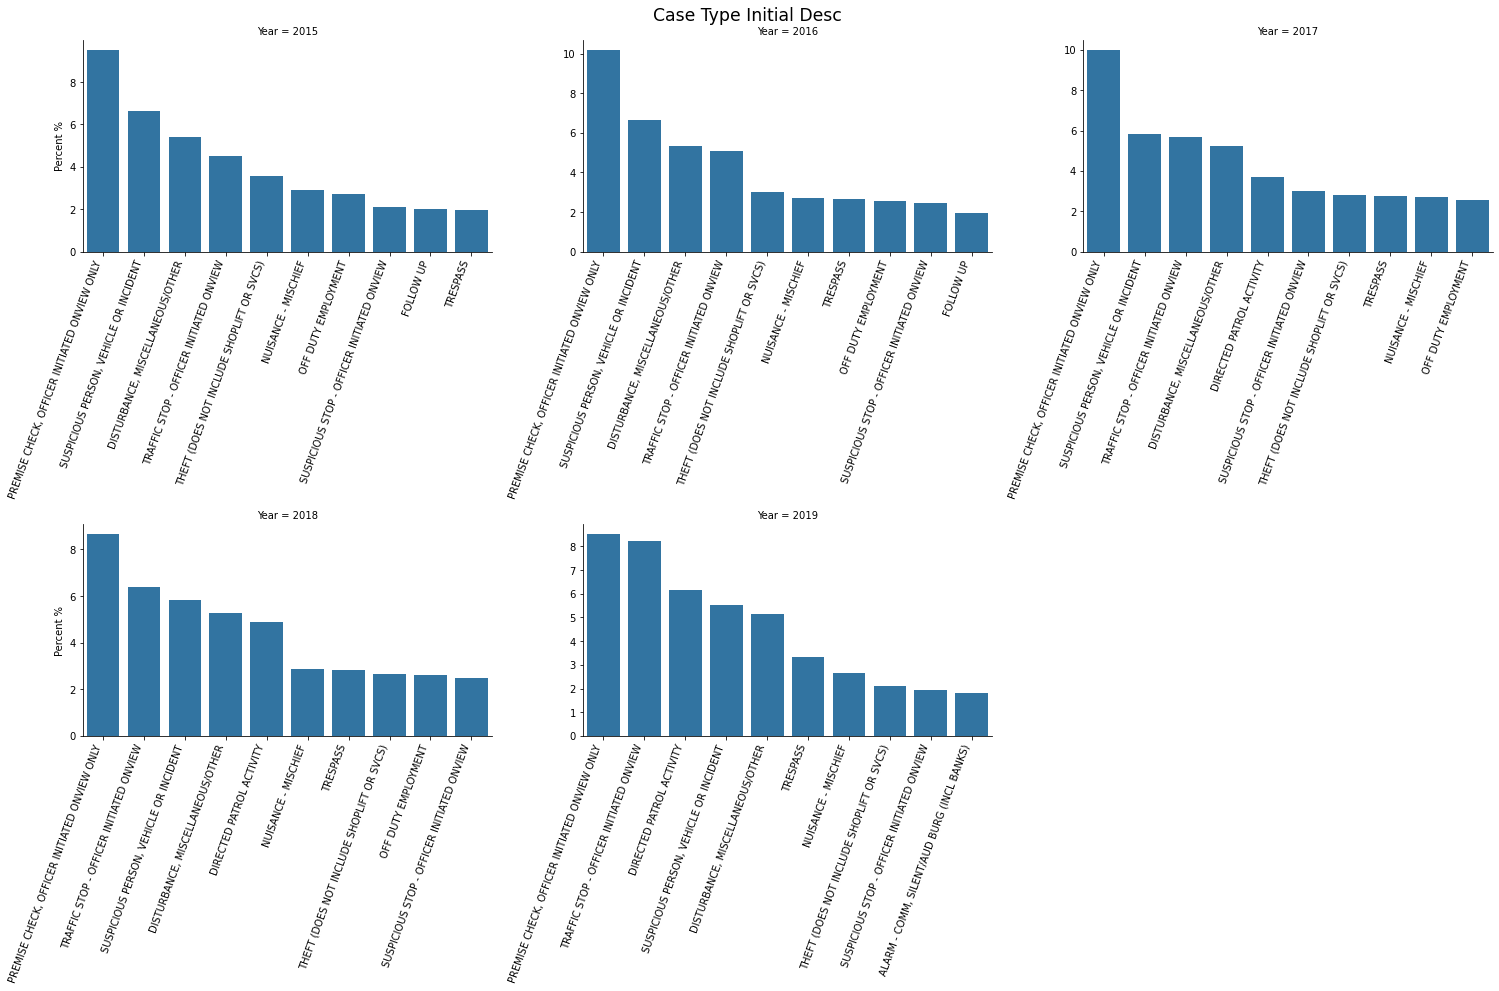

In [279]:
# Case type initial
barplot_by_year(
    df, var_colname="Case Type Initial Desc", col_wrap=3, height=7, aspect=1
)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


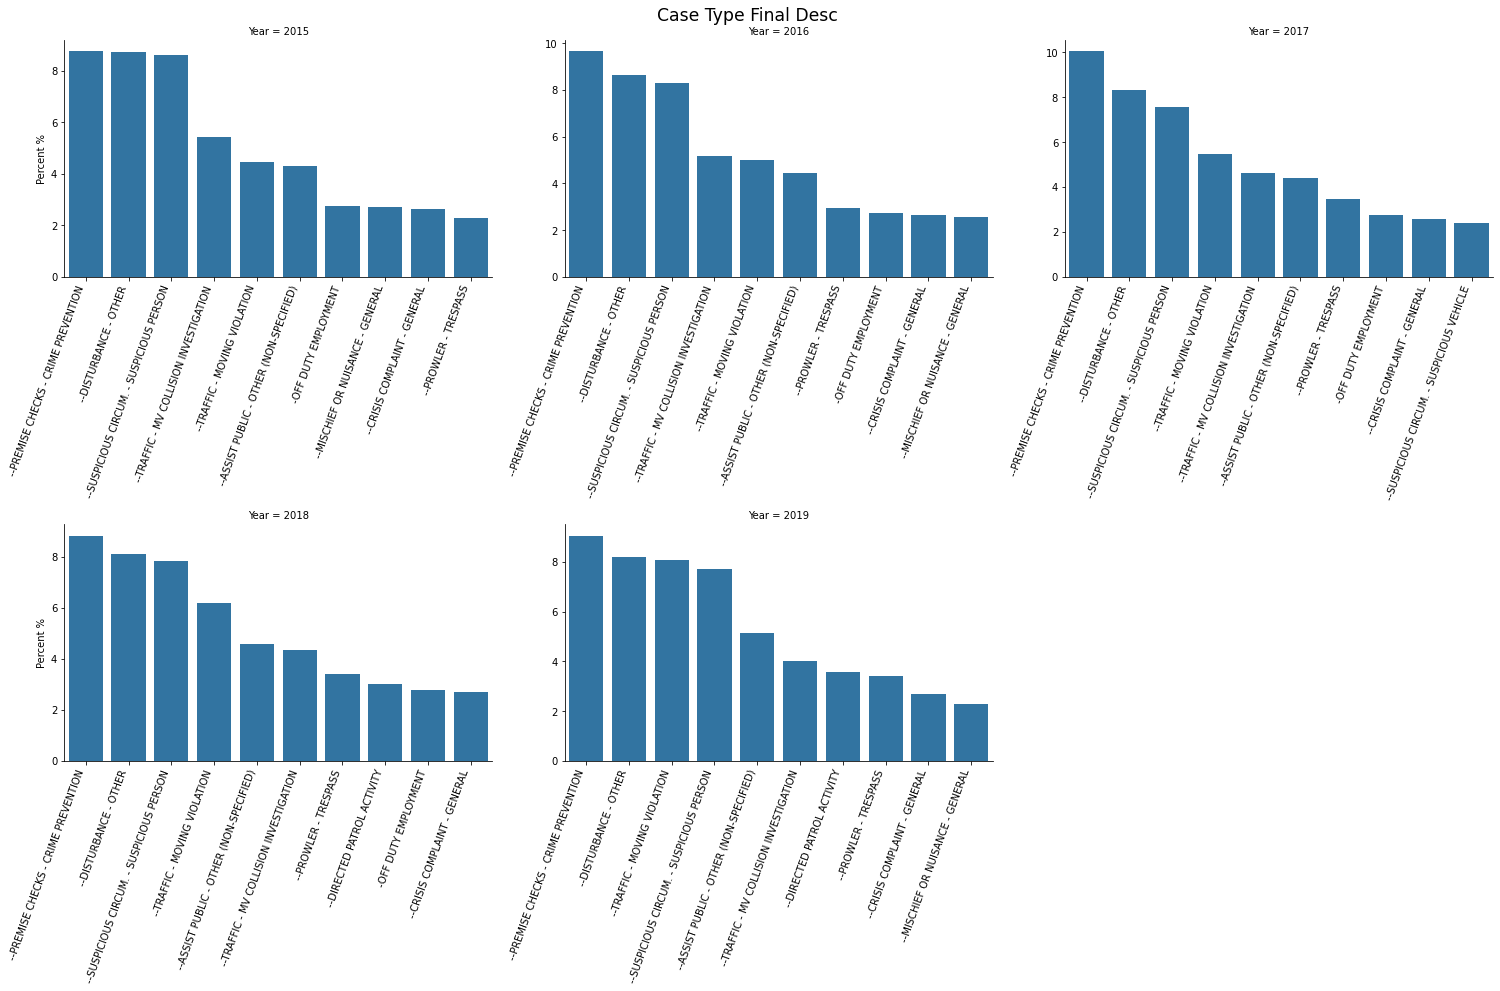

In [280]:
# Case type final
barplot_by_year(df, var_colname="Case Type Final Desc", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


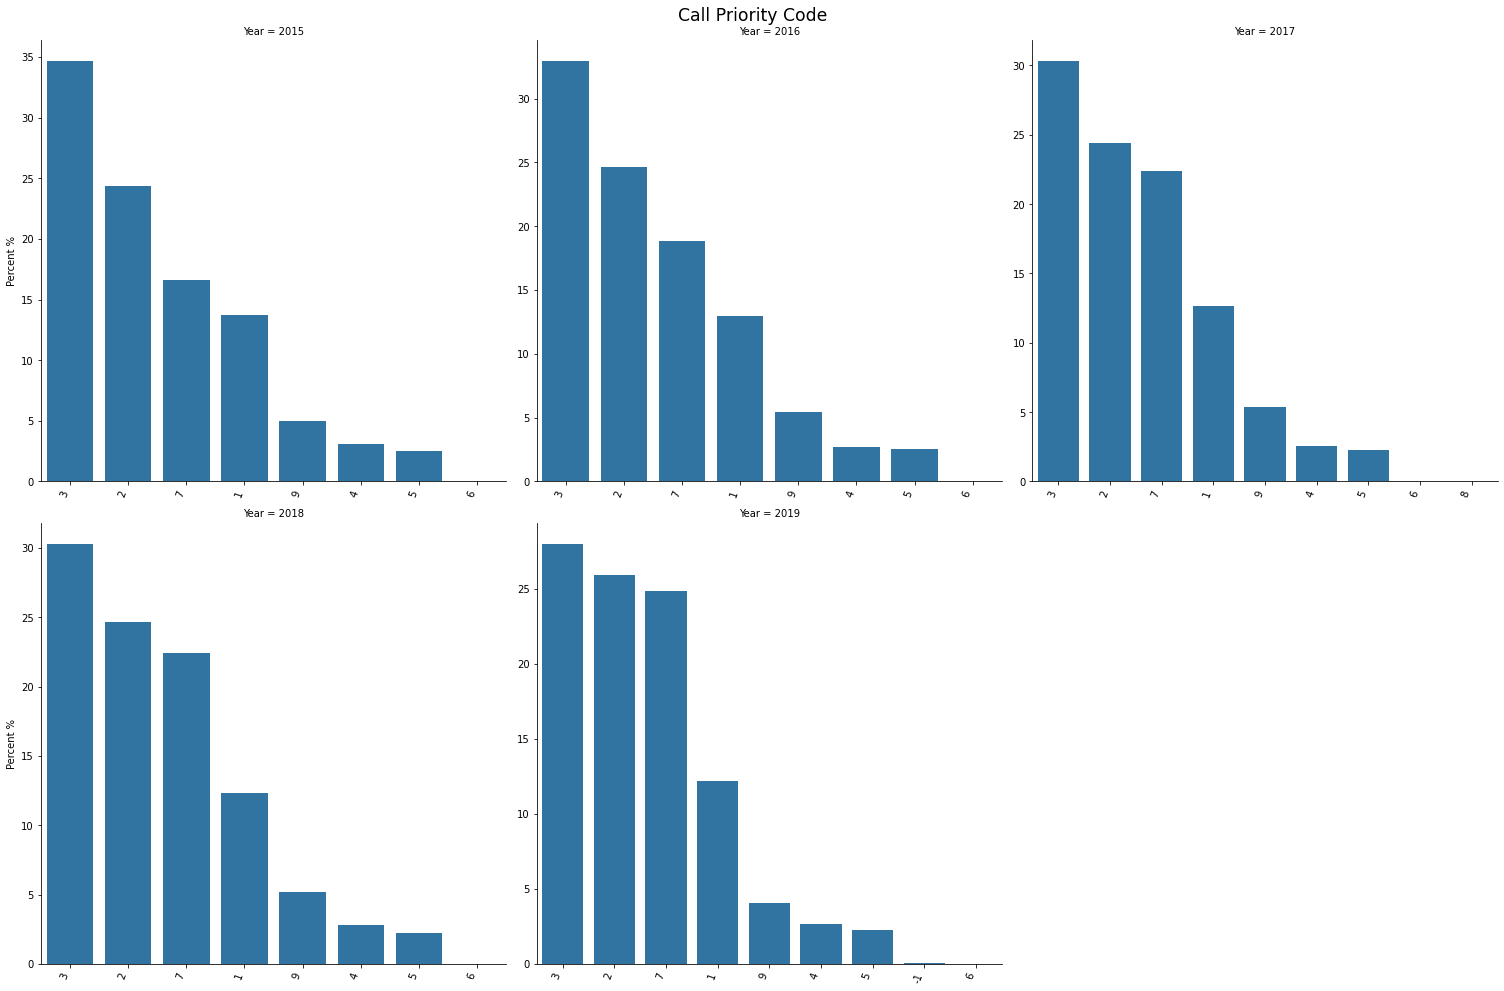

In [281]:
# Call priority code
barplot_by_year(df, var_colname="Call Priority Code", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


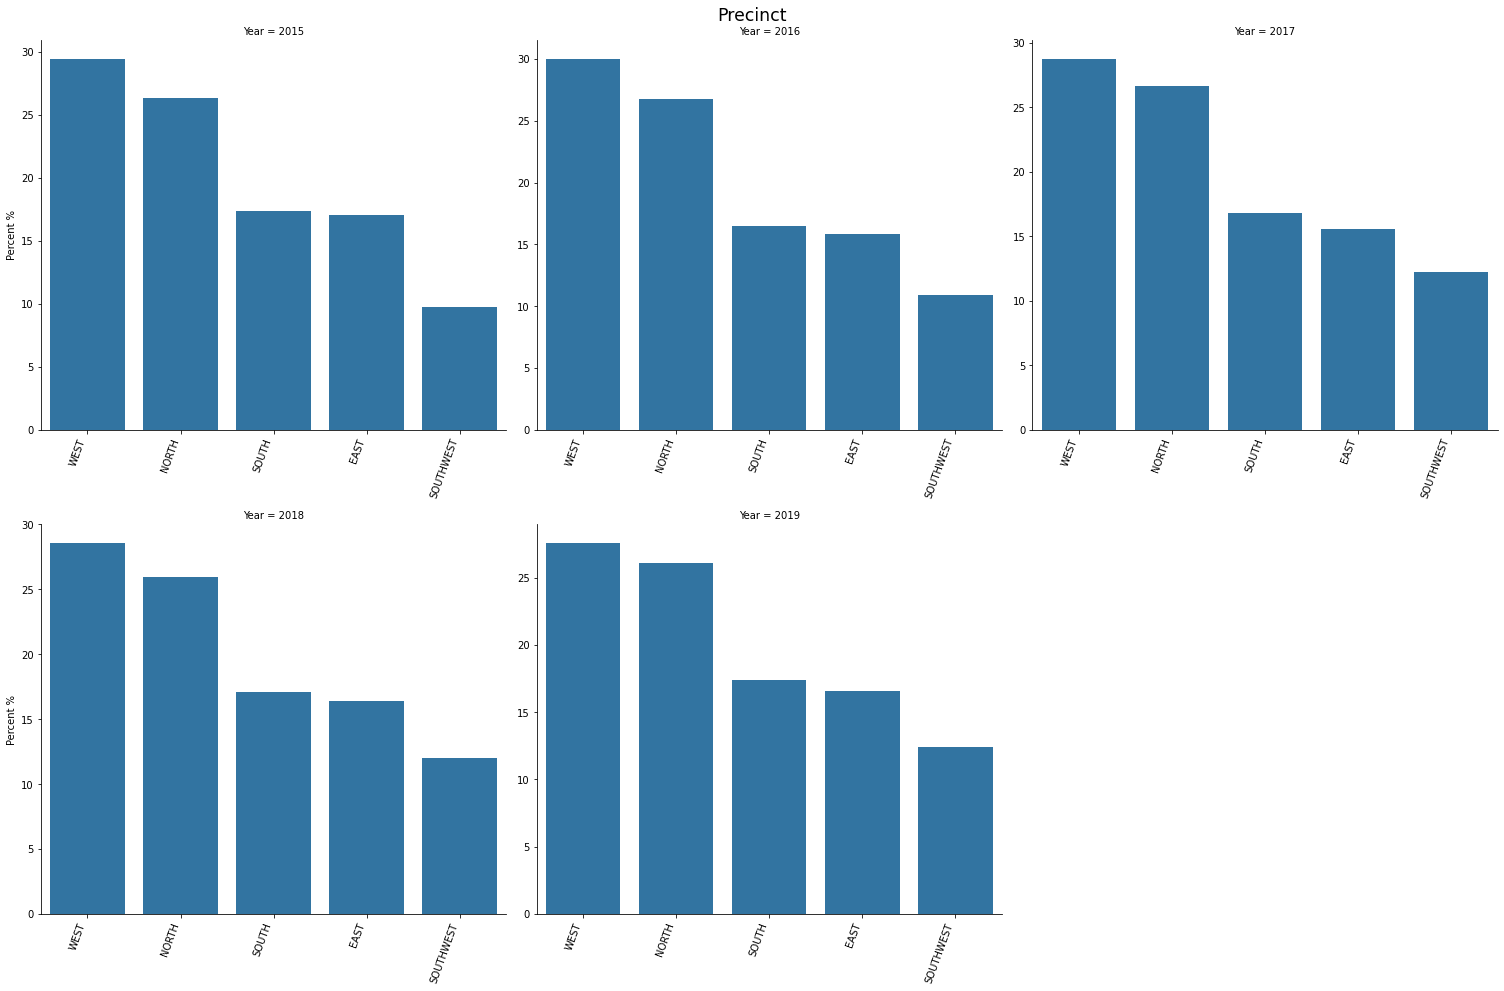

In [282]:
# Precinct
barplot_by_year(df, var_colname="Precinct", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


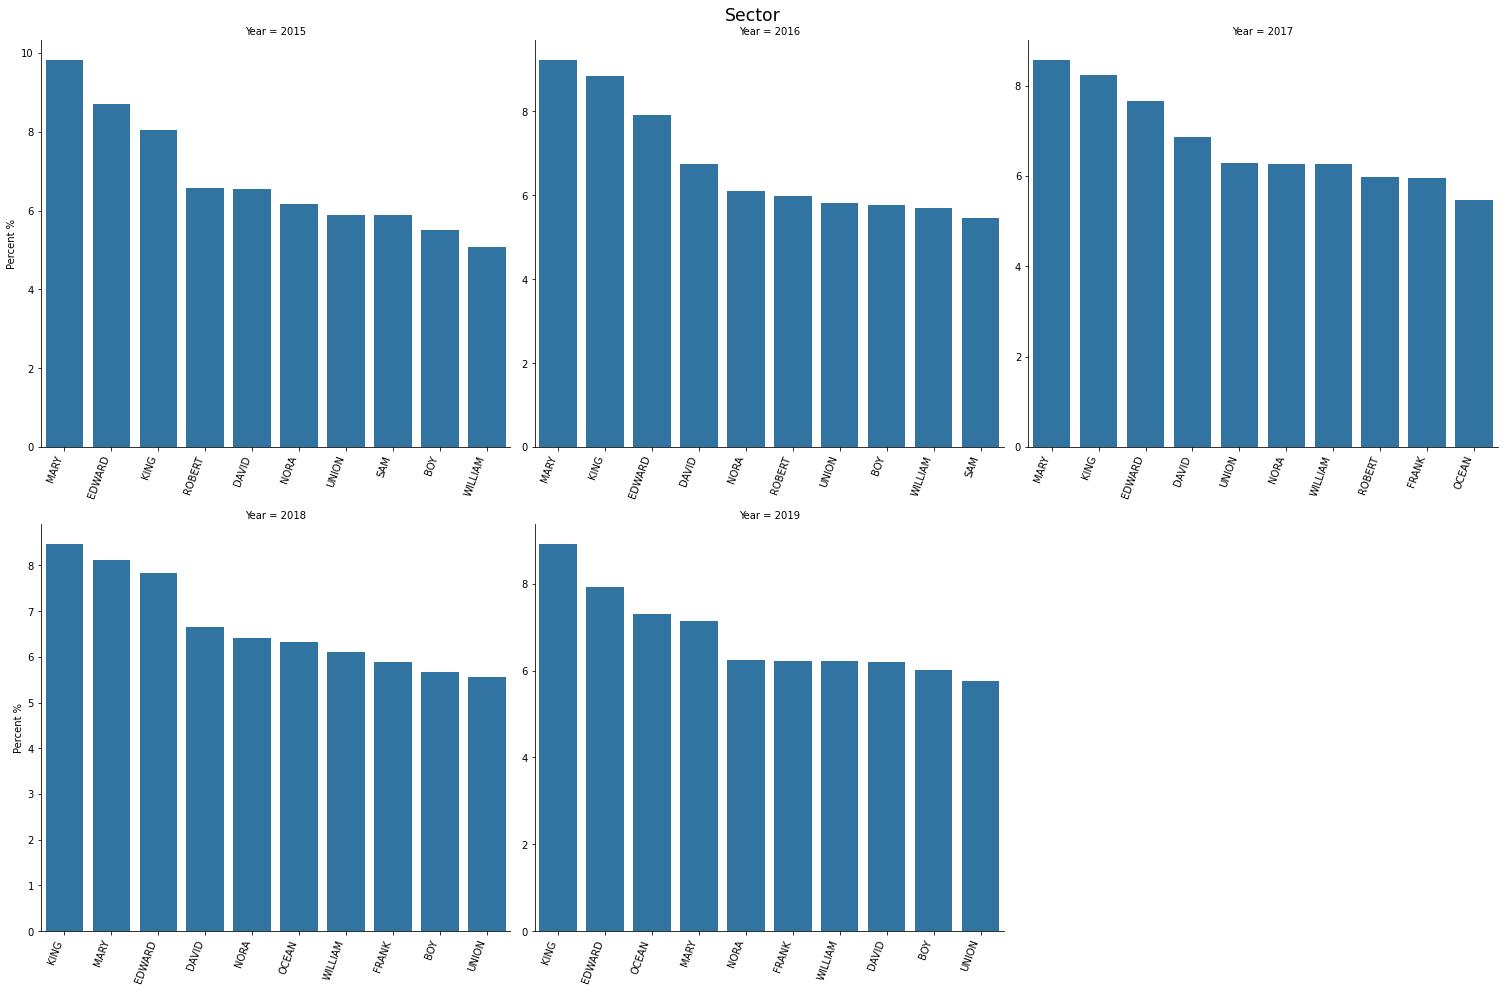

In [283]:
# Sector
barplot_by_year(df, var_colname="Sector", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


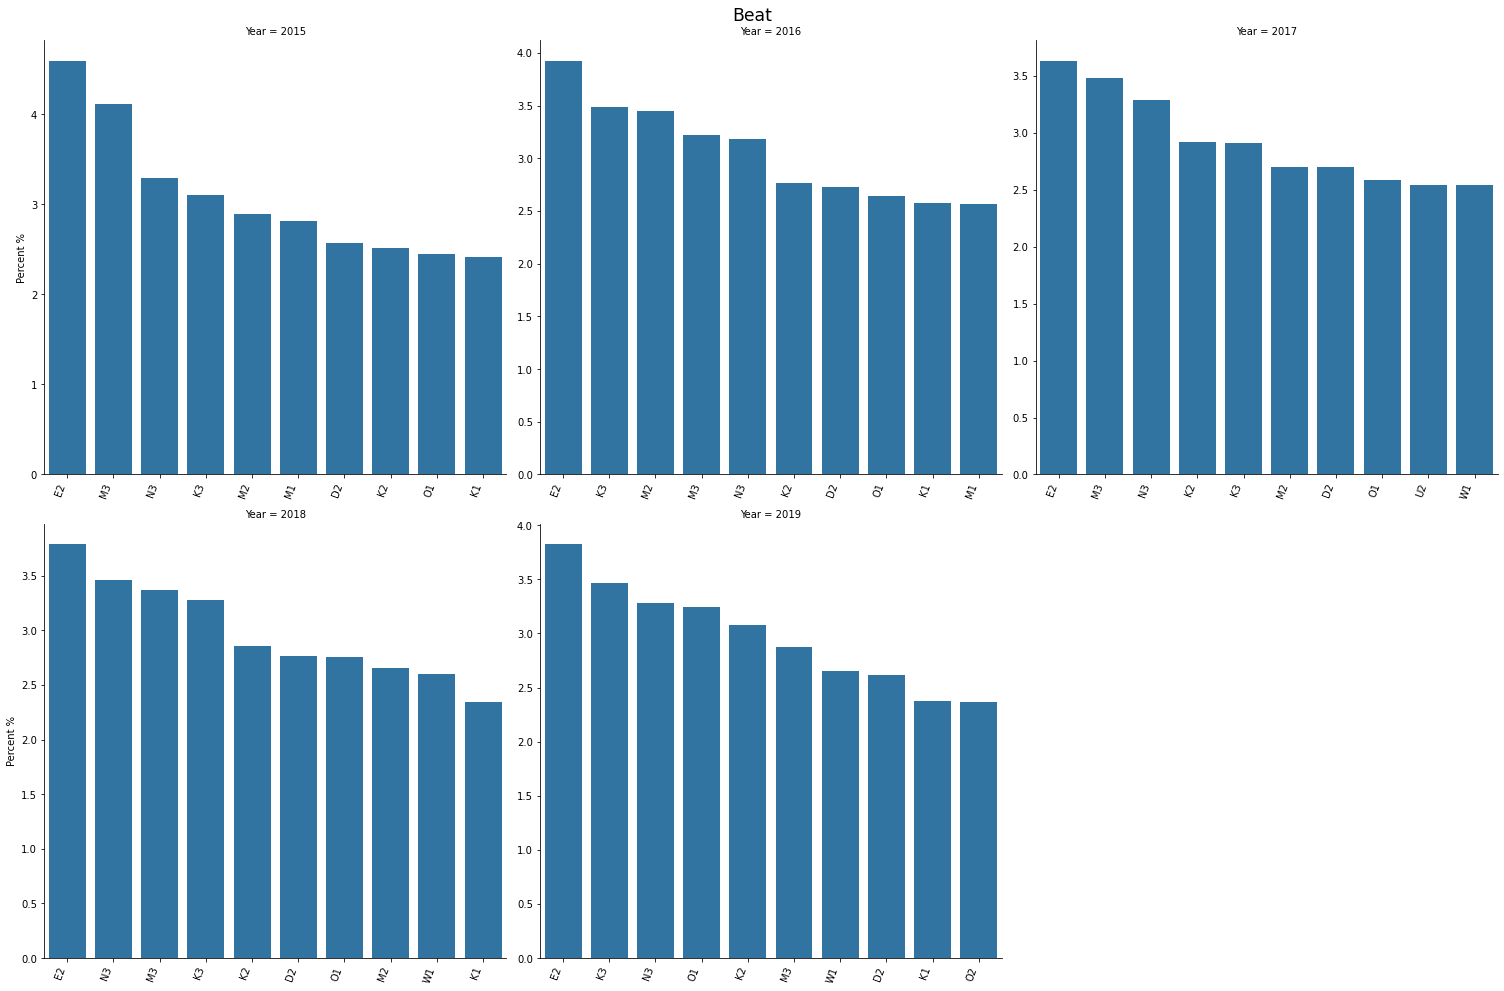

In [284]:
# Beat
barplot_by_year(df, var_colname="Beat", col_wrap=3, height=7, aspect=1)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


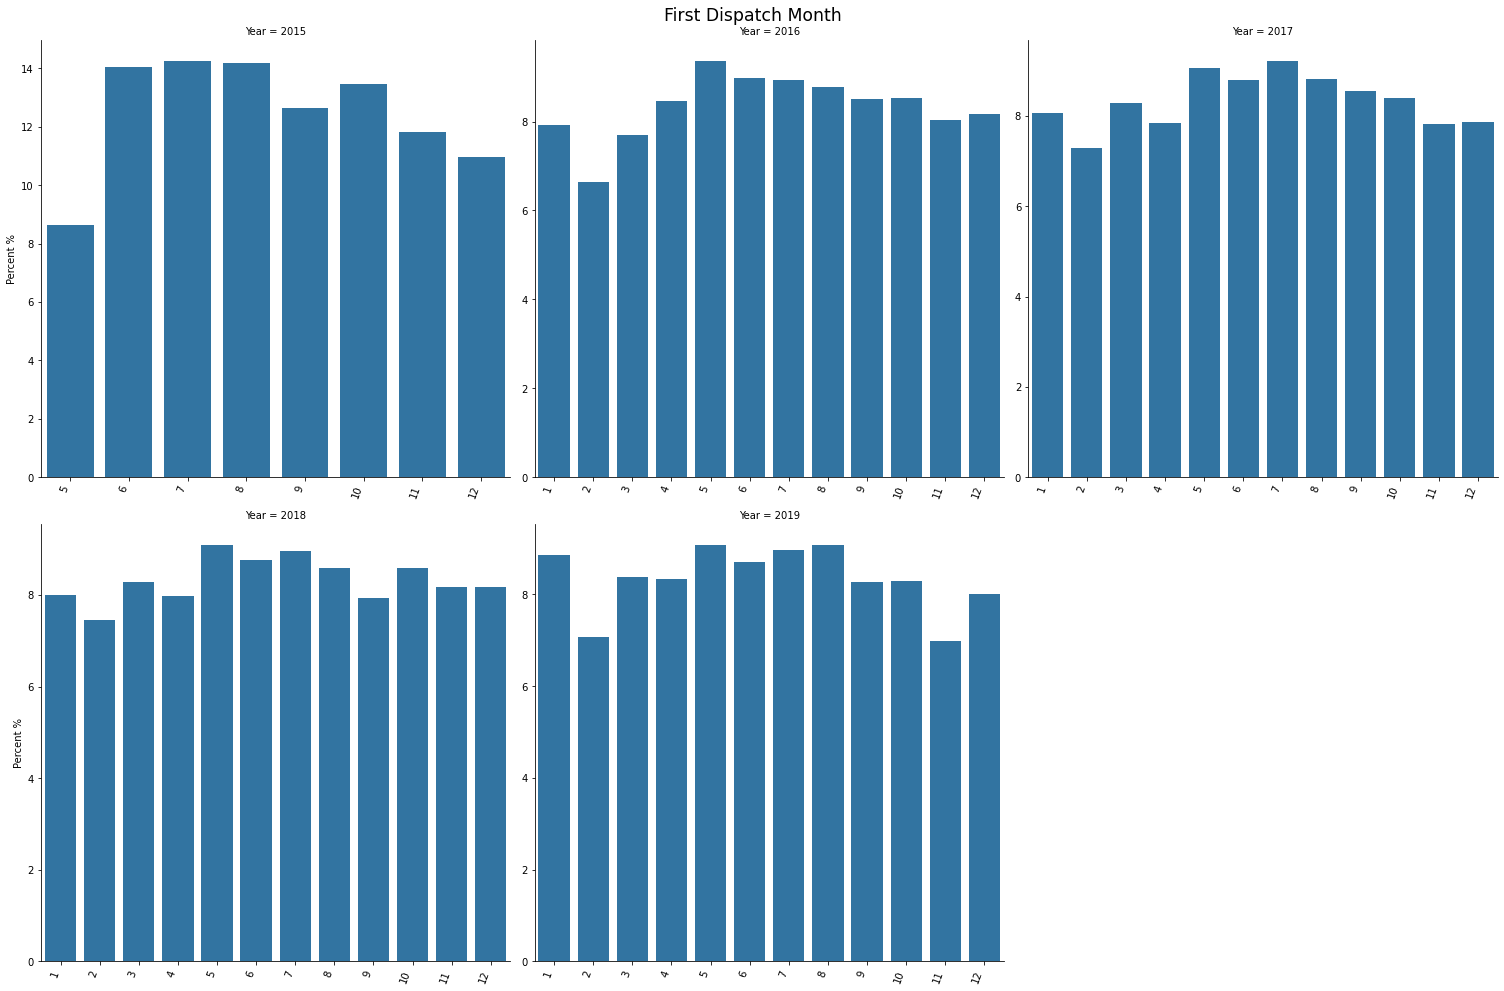

In [285]:
barplot_by_year(
    df, var_colname="First Dispatch Month", col_wrap=3, height=7, aspect=1, top_n=12
)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


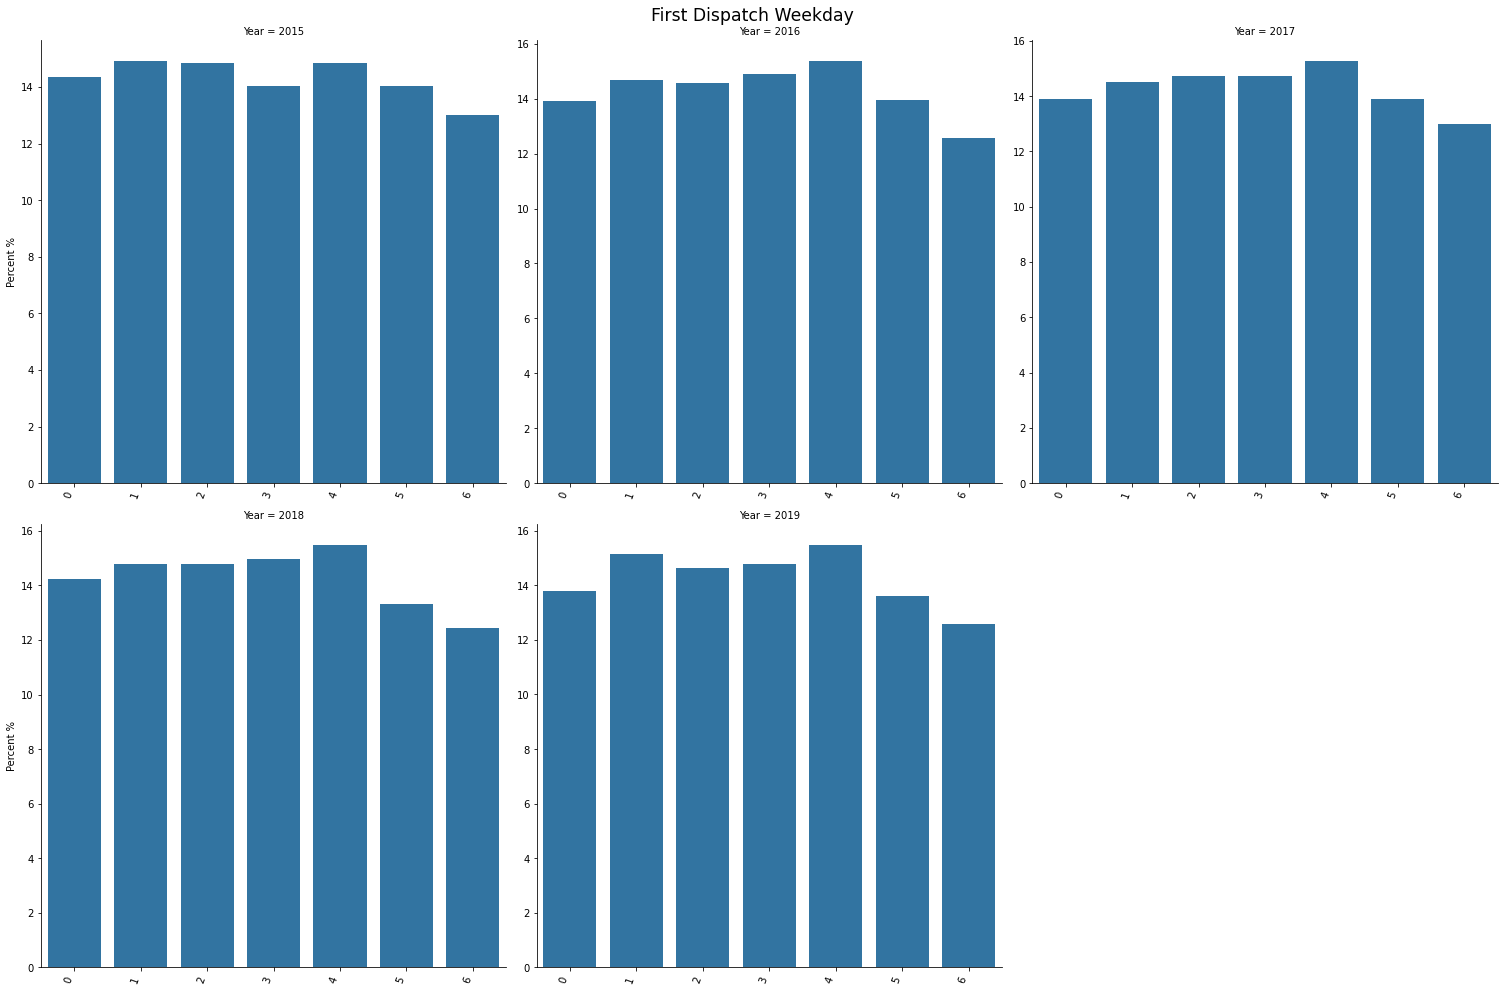

In [286]:
barplot_by_year(
    df, var_colname="First Dispatch Weekday", col_wrap=3, height=7, aspect=1
)

/Users/senosam/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


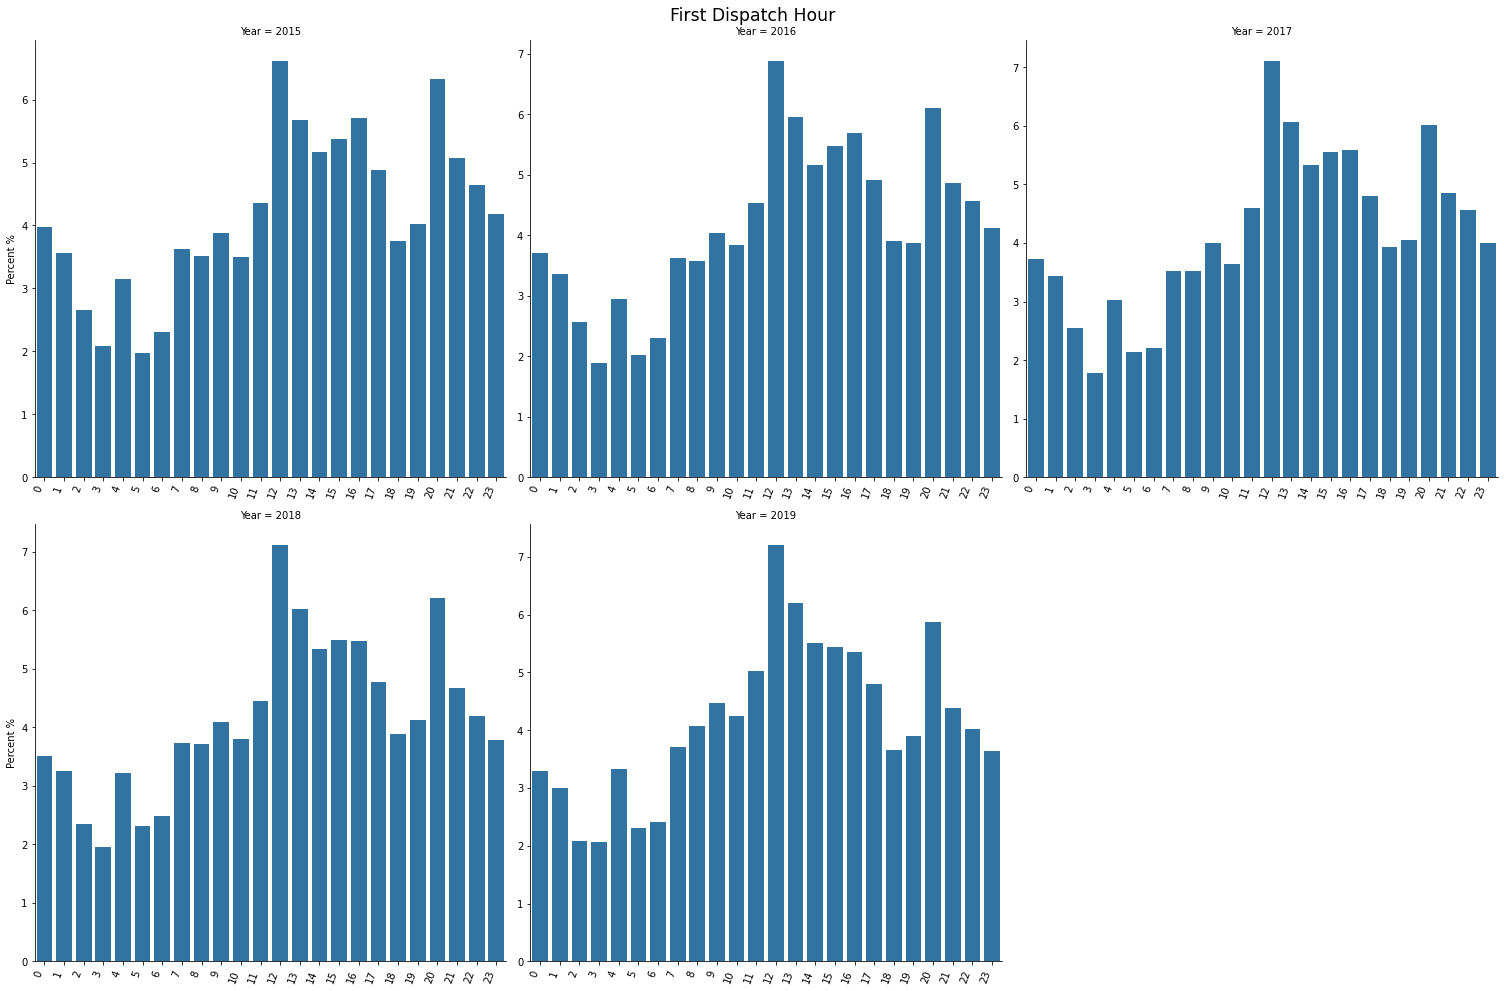

In [287]:
barplot_by_year(
    df, var_colname="First Dispatch Hour", col_wrap=3, height=7, aspect=1, top_n=24
)

## Exploring bivariate distributions

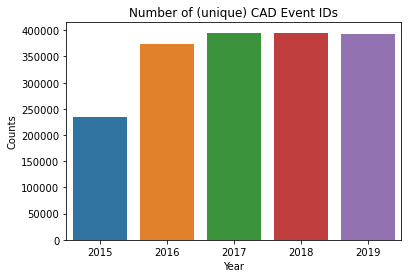

In [288]:
# Unique CAD Event IDs per year
var_df = df[["Year", "CAD Event ID"]].drop_duplicates()
var_df_counts = (
    var_df.groupby(["Year"]).size().sort_values(ascending=False).reset_index()
)
ax = sns.barplot(x="Year", y=0, data=var_df_counts)
plt.ylabel("Counts")
plt.title("Number of (unique) CAD Event IDs")
plt.show()

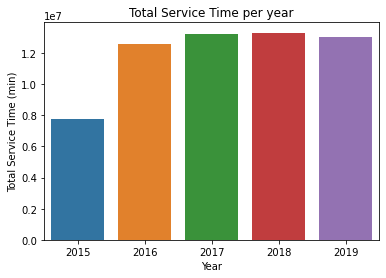

In [289]:
# Total Service Time per year
var_df = df[["Year", "CAD Event ID", "Total Service Time"]].drop_duplicates()
var_df_counts = var_df.groupby(["Year"]).sum("Total Service Time").reset_index()
var_df_counts
ax = sns.barplot(x="Year", y="Total Service Time", data=var_df_counts)
plt.ylabel("Total Service Time (min)")
plt.title("Total Service Time per year")
plt.show()

In [290]:
def boxplot_servicetime(df, col_name, top_n=10):
    var_df = df
    var_df.drop(df[df[col_name] == "-"].index, inplace=True)

    if len(var_df[col_name].unique()) < top_n:
        top_n = len(var_df[col_name].unique())

    top_vars = (
        var_df.groupby([col_name])
        .median()["Total Service Time"]
        .sort_values(ascending=False)
        .reset_index()[col_name]
        .head(top_n)
        .tolist()
    )
    var_df_top = var_df.loc[var_df[col_name].isin(top_vars)]
    ax = sns.boxplot(x=col_name, y="Total Service Time", data=var_df_top)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, horizontalalignment="right")
    ax.set_title(col_name)
    None

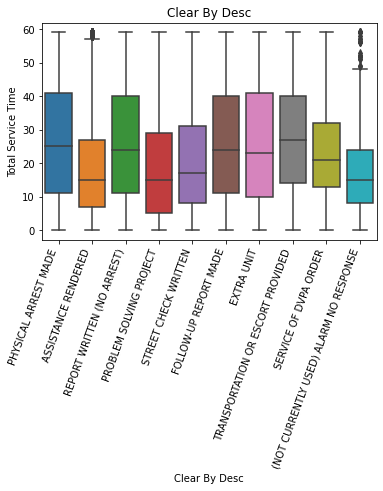

In [291]:
boxplot_servicetime(df, col_name="Clear By Desc")

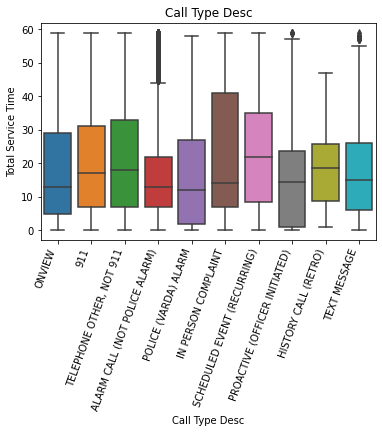

In [292]:
boxplot_servicetime(df, col_name="Call Type Desc")

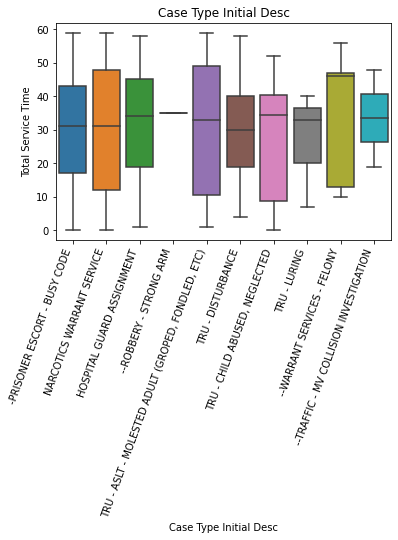

In [293]:
boxplot_servicetime(df, col_name="Case Type Initial Desc")

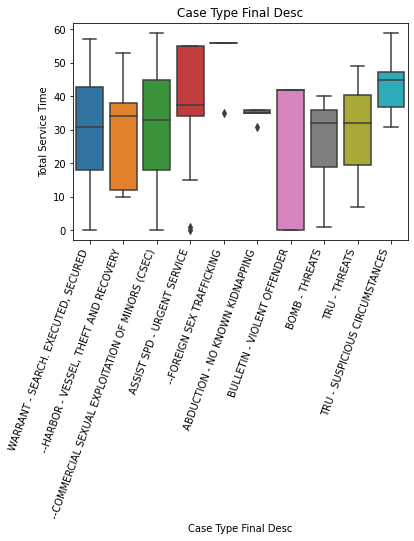

In [294]:
boxplot_servicetime(df, col_name="Case Type Final Desc")

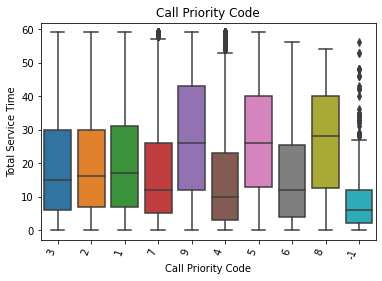

In [295]:
boxplot_servicetime(df, col_name="Call Priority Code")

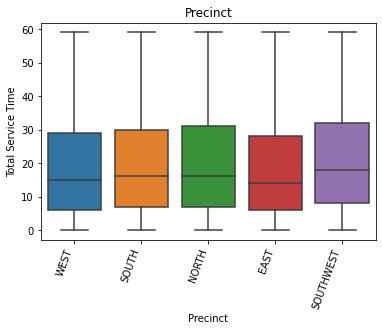

In [296]:
boxplot_servicetime(df, col_name="Precinct")

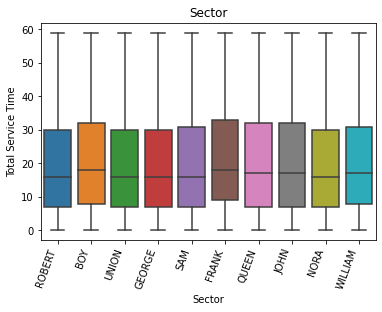

In [297]:
boxplot_servicetime(df, col_name="Sector")

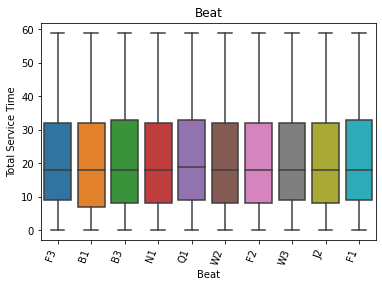

In [298]:
boxplot_servicetime(df, col_name="Beat")

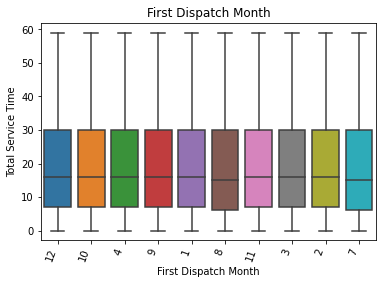

In [299]:
df["First Dispatch Month"] = df["First Dispatch Month"].astype(str)
boxplot_servicetime(df, col_name="First Dispatch Month")

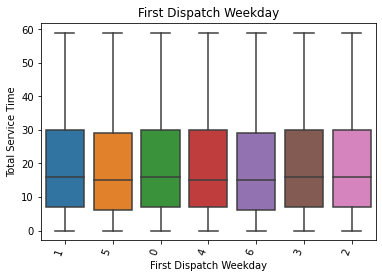

In [300]:
df["First Dispatch Weekday"] = df["First Dispatch Weekday"].astype(str)
boxplot_servicetime(df, col_name="First Dispatch Weekday")

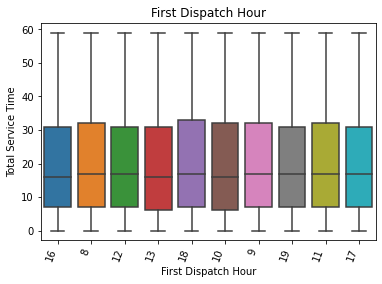

In [301]:
df["First Dispatch Hour"] = df["First Dispatch Hour"].astype(str)
boxplot_servicetime(df, col_name="First Dispatch Hour")